In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from __future__ import absolute_import
from extract_data import extract_data
from finbeat_calc import finbeat_calc
from store_data import store_data
from read_data import read_data
from make_subset import make_subset
from plot_accel import plot_accel
from plot_track import plot_track
from check_plots import check_plots
from plot_analysis import plot_analysis
from sin_corr import sin_corr
from plot_fit_sine import plot_fit_sine

# Read stored data
tracklist, finbeats, finbeat_byP, finbeat_byT = read_data('data.pickle')

In [2]:
bass_subset = make_subset(group_by1='species', identifier1='Bass', tracklist=tracklist)
bass_burst_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
bass_steady_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
bass_linacc_subset = make_subset(group_by1 = 'species', identifier1='Bass', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

trout_subset = make_subset(group_by1 = 'species', identifier1 ='BTrout', tracklist=tracklist)
trout_burst_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='B')
trout_steady_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='S')
trout_linacc_subset = make_subset(group_by1 = 'species', identifier1='BTrout', 
                                 tracklist=tracklist, group_by2 = 'behavior', identifier2='A')

In [3]:
#corr_w_sin = sin_corr(tracklist.keys(), tracklist, finbeat_byT)
#plot_fit_sine(bass_subset, tracklist, corr_w_sin)

In [17]:
speeds = [0]*len(tracklist.keys())
count= 0

for i in tracklist.keys():
    speeds[count] = tracklist[i]['start_spd']
    count+=1

print(max(speeds))

52.2476


In [44]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


def plot_analysis_forfig(rows, columns, number, finbeats_subset,
                         finbeat_data, tracklist, zaxis='A', lines=True,
                         cutoff=False):
    """Plots finbeats in (period, amplitude, acceleration) space.

    This function takes finbeat data from a specified output of
    finbeat_calc(), and plots each individual finbeat in (period,
    amplitude, maximum acceleration) space. The finbeat_data argument
    specifies whether the finbeats to be plotted come from peak-to-peak
    or trough-to-trough calculations. The maximum acceleration is the
    maximum acceleration between the finbeat start and finbeat end
    times. The number of total finbeats is printed at the end.

    Args:
        subset_name (string): some string identifying what's in your
                                subset, to be used as the plot title
        finbeats_subset (list): a list of strings with the trial
                            names of the desired trials from finbeats.
                             Note: The list (even of a single
                             element) must be contained in square
                             brackets. You'll probably want to use
                             the subset generating function:
                             make_subset()
        finbeat_data (dict): use either finbeat_byP to do analysis
                            on finbeats as defined by peaks first,
                            or finbeat_byT to use finbeats defined by
                            troughs first. These must be created
                            beforehand by the function finbeat_calc()
        zaxis (str): must be of value "A" or "V". Indicates whether to plot
                        acceleration or velocity.
        tracklist (dict): the compiled position, velocity,
                          and acceleration data for all trials
                           produced by extract_data()
        lines (Bool): if True, adds lines up from x-y plane to z_value
        cutoff (Bool): if True, cuts off z axis at hard-coded maximum value
        save (Bool): if True, saves to svg instead of printing to screen

    Returns:
        Nothing
    """
    count_n = 0  # start counting finbeats

    # find max initial speed for coloring by speed
    speeds = []
    for trial in finbeats_subset:
        speeds.append(tracklist[trial]['start_spd'])
    max_spd = max(speeds)

    # find x and y max and min axis limits
    x_vals = []
    y_vals = []
    z_vals = []
    for trial in finbeats_subset:
        for finbeat in finbeat_data[trial].index.values:
            x_vals.append(finbeat_data[trial]['period'][finbeat])
            y_vals.append(finbeat_data[trial]['amplitude'][finbeat])

    x_max = np.nanmax(x_vals)
    y_max = np.nanmax(y_vals)

    # Pull a colormap
    cm = plt.get_cmap("plasma")

    # Set up the figure and choose an appropriate z-axis label
    ax1 = fig2.add_subplot(rows, columns, number, projection='3d')
    ax1.set_xlabel('Period (s)')
    ax1.set_ylabel('Amplitude (cm)')
    if zaxis == 'V':
        ax1.set_zlabel('\nMax. Inst. Velocity(cm/s)')
    else:
        ax1.set_zlabel('\nMax. Acceleration (cm/s $^2$)')
    ax1.set_xlim3d(0, x_max)
    ax1.set_ylim3d(0, y_max)

    # for each trial of interest
    for trial in finbeats_subset:
        # for each finbeat within that trial
        for finbeat in finbeat_data[trial].index.values:
            # get the period
            # period_mask = finbeat_data[trial]['period'].loc[finbeat]
            period = finbeat_data[trial]['period'][finbeat]

            # get the amplitude
            # amplitude_mask = finbeat_data[trial]['amplitude'].loc[
            # finbeat]
            amplitude = finbeat_data[trial]['amplitude'][finbeat]

            # get the start time
            # start_mask = finbeat_data[trial]['time'].loc[finbeat]
            start = finbeat_data[trial]['time'][finbeat]
            # get the end time
            # end_mask = finbeat_data[trial]['endtime'].loc[finbeat]
            end = finbeat_data[trial]['endtime'][finbeat]

            # find the maximum acceleration or velocity in that time range
            if zaxis == 'A':
                zcolumn = tracklist[trial]['data'][
                              'pt1_net_a'][start:end].max()
                z_vals.append(zcolumn)
            elif zaxis == 'V':
                zcolumn = tracklist[trial]['data'][
                              'pt1_net_v'][start:end].max()
                z_vals.append(zcolumn)
            else:  # If they fuck up, make it acceleration
                zcolumn = tracklist[trial]['data'][
                              'pt1_net_a'][start:end].max()
                z_vals.append(zcolumn)

            # pull the initial speed and behavior
            init_spd = tracklist[trial]['start_spd']
            behavior_type = tracklist[trial]['behavior']
            if behavior_type == 'B':
                behavior = '*'
            elif behavior_type == 'A':
                behavior = '+'
            else:
                behavior = 'o'

            # add the point
            if cutoff == True and zaxis == 'A':
                z_max = 0.00005
            else:
                z_max = np.nanmax(z_vals)
            if zcolumn <= z_max and lines == True and zcolumn >= 0:
                p = ax1.plot(xs=[period, period], ys=[amplitude, amplitude],
                             zs=[0, zcolumn],
                             linestyle='solid', c=cm(init_spd / max_spd),
                             alpha=0.8, linewidth=0.5)
                p = ax1.scatter3D(xs=period,
                                  ys=amplitude,
                                  zs=zcolumn,
                                  zdir='z', s=50, marker=behavior,
                                  c=init_spd,
                                  cmap=cm, edgecolor='none', vmin=0,
                                  vmax=53)
                count_n += 1

    ax1.set_zlim3d(0, z_max)
    #cbar = plt.colorbar(p,shrink=0.7, pad = 0.1)
    #cbar.set_label('Initial Speed (cm/s)', rotation=270, labelpad=10)
    #if save == True:
        #plt.savefig(str(subset_name)+".svg", format="svg")
    #else:
        #plt.show()
    #print(count_n)

    return ax1

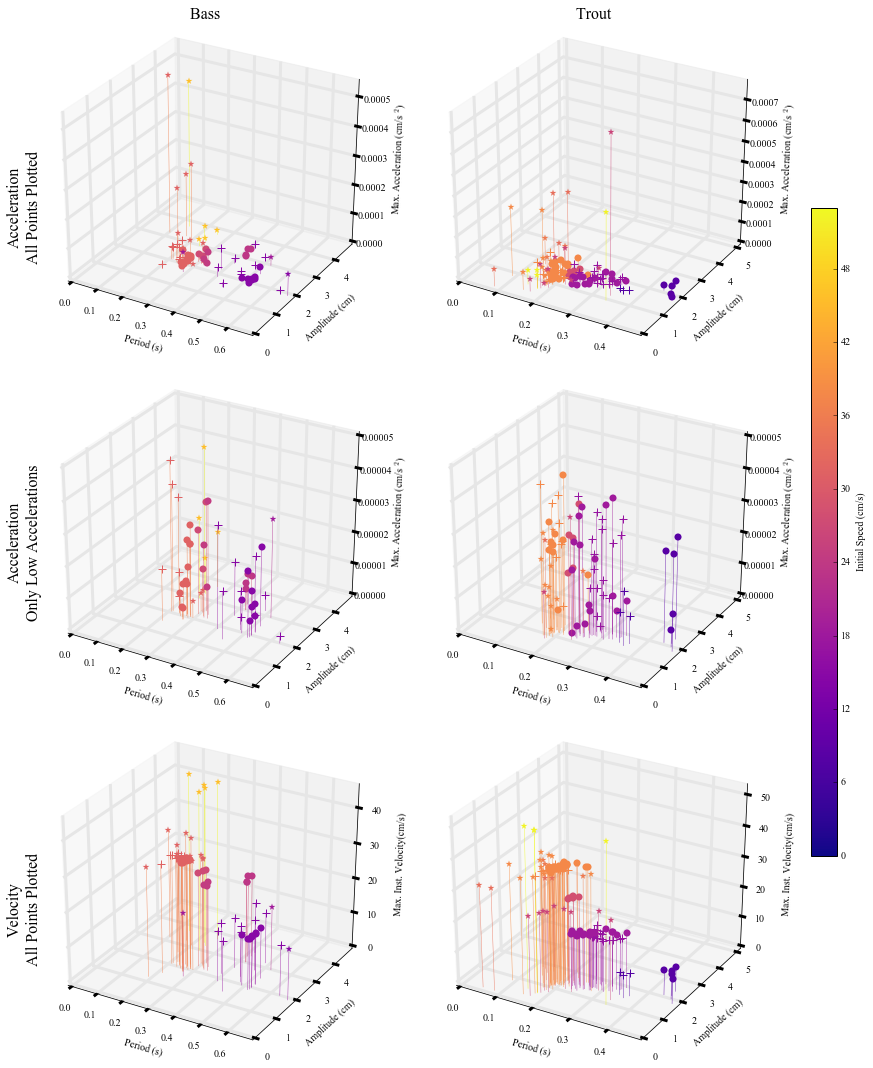

In [48]:
#import matplotlib
#import matplotlib.pyplot as plt
#from plot_analysis_forfig import plot_analysis_forfig

plt.style.use('mystyle.mplstyle')

fig2 = plt.figure(figsize = (12,15))

ax2_1 = plot_analysis_forfig(3,2,1, bass_subset, finbeat_byP, tracklist, 'A', True, False)  # Bass acc no cutoff
ax2_1.set_title('Bass \n')
ax2_2 = plot_analysis_forfig(3,2,2, trout_subset, finbeat_byP, tracklist, 'A', True, False)  # Trout accel no cutoff
ax2_2.set_title('Trout \n')
ax2_3 = plot_analysis_forfig(3,2,3, bass_subset, finbeat_byP, tracklist, 'A', True, True)  # Bass accel cutoff
ax2_4 = plot_analysis_forfig(3,2,4, trout_subset, finbeat_byP, tracklist, 'A', True, True)  # Trout accel cutoff
ax2_5 = plot_analysis_forfig(3,2,5, bass_subset, finbeat_byP, tracklist, 'V', True, False)  # Bass inst velocity
ax2_6 = plot_analysis_forfig(3,2,6, trout_subset, finbeat_byP, tracklist, 'V', True, False)  # Trout inst. velocity


fig2.text(0, 0.8, 'Acceleration\nAll Points Plotted\n ', va='center', rotation='vertical', fontsize=16, multialignment = 'center')
fig2.text(0, 0.49, 'Acceleration\nOnly Low Accelerations\n ', va='center', rotation='vertical', fontsize=16, multialignment = 'center')
fig2.text(0, 0.15, 'Velocity\nAll Points Plotted\n ', va='center', rotation='vertical', fontsize=16, multialignment = 'center')
#plt.show()
plt.tight_layout()
fig2.subplots_adjust(right=0.9)
cbar_ax = fig2.add_axes([0.93, 0.2, 0.03, 0.6])  # [left, bottom, width, height]
cbar_ax.set_xmargin(0.2)
cmap = matplotlib.cm.plasma
norm = matplotlib.colors.Normalize(vmin=0, vmax=53)
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Initial Speed (cm/s)')

fig2.savefig('Fig2_IndividualFinbeats.pdf', fmt = 'pdf')




In [ ]:
import matplotlib.pyplot as plt
import pywt 
from scipy import signal

testdata = tracklist['Bass1S09']['data']['pt2y_smth']
time = tracklist['Bass1S09']['data'].index.values
framerate = float(tracklist['Bass1S09']['FPS'])
scales = np.arange(2,20,1)


wavelet_choice = pywt.Wavelet('bior3.1')
print(wavelet_choice)
for i in np.arange(2,20,1):
    freq = pywt.scale2frequency(wavelet_choice, i)
    print(': scale=',i, ' freq=', freq)

In [ ]:
for name in pywt.wavelist(kind='discrete'):
    x = time
    data = testdata
    wavelet = name
    level = 1
    order = 'freq'
    interpolation = 'nearest'
    cmap = plt.cm.cool

    wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel = level)
    nodes = wp.get_level(level, order = order)
    labels = [n.path for n in nodes]
    values = np.array([n.data for n in nodes], 'd')
    values = abs(values)
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
    ax = fig.add_subplot(2, 1, 1)
    ax.set_title("Data")
    ax.plot(x, data, 'b')
    ax.set_xlim(0, x[-1])

    ax = fig.add_subplot(2, 1, 2)
    ax.set_title("Wavelet packet coefficients at level %d" % level)
    ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
              origin="lower", extent=[0, 1, 0, len(values)])
    ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

    # Show spectrogram and wavelet packet coefficients
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(211)
    ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
                 interpolation='bilinear')
    ax2.set_title("Spectrogram of signal")
    ax3 = fig2.add_subplot(212)
    ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
               interpolation='nearest')
    ax3.set_title("Wavelet packet coefficients")


    plt.show()



In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import pywt


x = np.linspace(0, 1, num=512)
data = np.sin(250 * np.pi * x**2)

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()